In [13]:
# Pendrak Oleg Bi17-2 https://github.com/penolegrus/mlhomework/blob/master/3%D0%BB%D0%B0%D0%B1%D0%B0/Untitled.ipynb
import numpy as np
import pandas as pd 
import json # чтоб сделать из json Фрейм
from pandas.io.json import json_normalize # чтоб нормализовать json файл
from sklearn import preprocessing # импорт для проставки категорий 
import warnings
warnings.simplefilter('ignore', FutureWarning)
import seaborn as sns

In [4]:
def cut_for_speed(obj): # 10 процентов строк для ускорения
    msk = np.random.rand(len(obj)) < 0.1
    new_obj = obj[msk]
    return new_obj

In [5]:
def json_convert(df, JSON_COLUMNS): # преобразование Json 
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f'{column}.{subcolumn}' for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [7]:
JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
data = pd.read_csv("train.csv", sep = ",",  dtype = {'fullVisitorId': 'str'},
                   converters={column: json.loads for column in JSON_COLUMNS}, 
                   nrows = None)
data = json_convert(data, JSON_COLUMNS) # конверт json
data = cut_for_speed(data) # Отрезаем 10 процентов 

#  отчистка от мусора
delete = data.ne('not available in demo dataset')
data = data.loc[delete.any(1), delete.any()]


In [8]:
def prepare_data(df):        
    
    
    df = df.replace({'socialEngagementType': {'Engaged': True, 'Not Socially Engaged': False}})  # bools
    
    float_cols = ['totals.pageviews','totals.bounces','totals.transactionRevenue'] # Тут массивы на флот и цикл на флот и нан делаем нулями
    for col in float_cols:
        df[col].fillna(0, inplace=True)
        df[col] = df[col].astype(float)
    df['totals.transactionRevenue'] = np.log1p(df['totals.transactionRevenue'].values)  # Сразу считаем логарифм прибыли
    
    str_cols = ['device.browser','geoNetwork.subContinent','geoNetwork.region',
                'geoNetwork.networkDomain','trafficSource.medium'] # тут массив на стринги и цикл с le le обучаем на уникальных значениях
    for col in str_cols:
        df = df.replace({col: {'not available in demo dataset': '(not set)'}}) # замена "Не доступно в демосете" на not set
        le = preprocessing.LabelEncoder()
        le.fit(df[col].unique())
        df[col] = le.transform(list(df[col].values.astype('str')))
        df[col] = df[col].astype(float)
    
    for columns in df.columns: # тут цикл где все что объект и инты сносим 
        if df[columns].dtype == 'object' or df[columns].dtype == 'int64':
            df = df.drop([columns], axis = 1)
    
    return df

In [9]:
data = prepare_data(data)

In [10]:
# Модельки
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


trg = data['totals.transactionRevenue']  # Отделяем от выборки значение зависимой переменной
trn = data.drop(columns=['totals.transactionRevenue'], axis=1)
Xtrn, Xtest, Ytrn, Ytest = train_test_split(trn, trg, test_size = 0.2) # Разбиваем выборку на тестовую и обучающую

models = [GradientBoostingRegressor(), # Градиентный бустинг
          RandomForestRegressor(), # Случайный лес
          # SVR(kernel='linear'), # Эпсилон-опорная векторная регрессия.Долгая очень очень
          LinearRegression() # Линейная регрессия
	     ]

In [11]:
# создание коллекций
Result = pd.DataFrame() 
tmp = pd.DataFrame() 

for model in models:
# получаем имя модели
   m = str(model)
   model_name = m[:m.index('(')]  
   # Кросс валидация
   scores = np.array([])
   for i in range(10):  # 10 разбиений
       fold = KFold(n_splits=5, shuffle=True)
       scores_on_this_split = cross_val_score(
               estimator = model, X=Xtest, y=Ytest,
               cv=fold, scoring='r2')
       scores = np.append(scores, scores_on_this_split)
   print('Отработала', model_name ) 
   tmp['Оценки качества'] = pd.Series(scores)
   tmp['Модель'] = model_name
   # записываем данные и итоговый DataFrame
   Result = Result.append([tmp])

Отработала GradientBoostingRegressor
Отработала RandomForestRegressor
Отработала LinearRegression


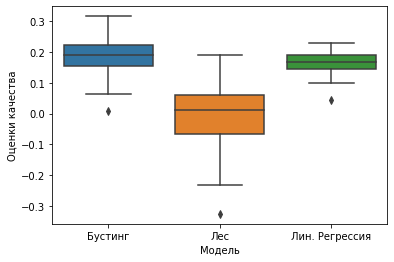

In [12]:
# Ящик с усами   
Result = Result.replace({'Модель': {'GradientBoostingRegressor': 'Бустинг', 'RandomForestRegressor': 'Лес', 'LinearRegression': 'Лин. Регрессия'}})  # Тут конвертим булики 
sns.boxplot(y = 'Оценки качества', x = 'Модель', data = Result) 